# Using the Timeseries API


This tutorial provides an overview of the Timeseries API, which is used to query for simulation input commands, simulation output data, weather data, and output for the GridAPPS-D Sensor Service. 

__Learning Objectives:__

At the end of the tutorial, the user should be able to use the Timeseries to

* obtain weather data
* obtain measurements from simuation data using measurement mRIDs
* obtain equipments commands and other simulation input data
* obtain simulated field data from the Sensor Service


## Getting Started

Before running any of the sample routines in this tutorial, it is first necessary to start the GridAPPS-D Platform and establish a connection to this notebook so that we can start passing calls to the API.

_Open the Ubuntu terminal and start the GridAPPS-D Platform __if it is not running already:___

`cd gridappsd-docker`

~/gridappsd-docker$ `./run.sh -t develop`

_Once containers are running,_

gridappsd@[container]:/gridappsd$ `./run-gridappsd.sh`

In [5]:
# Establish connection to GridAPPS-D Platform:
from gridappsd import GridAPPSD
gapps = GridAPPSD("('localhost', 61613)", username='system', password='manager')

For this tutorial, we will also need to run a demo simulation with the GridAPPS-D Sensor Simulator. When the simulation is complete, we will be able to query the results from the simulation.

In [5]:
import Run123NodeSensorServiceDemo as r
simulation_id = r.simulation.simulation_id

# Note: Restart and clear notebook kernel to re-run simulation

In [6]:
print(simulation_id)

1309924922


---
# Table of Contents

* [1. Introduction to the Timeseries API](#1.-Introduction-to-the-Timeseries-API)
* [2. Using the Timeseries API](#2.-Using-the-Timeseries-API)
    * [2.1. Specifying the GridAPPS-D Topic](#2.1.-Specifying-the-GridAPPS-D-Topic)
    * [2.2. Query Message Structure](#2.2.-Query-Message-Structure)
    * [2.3. Specifying the queryMeasurement](#2.3.-Specifying-the-queryMeasurement-value)
* [3. Querying for Timeseries Data](#3.-Querying-for-Timeseries-Data)
    * [3.1. Query for Weather Data](#3.1.-Query-for-Weather-Data)
        * [3.1.1. Interpreting GridAPPS-D Weather Data](#3.1.1.-Interpreting-GridAPPS-D-Weather-Data)
        * [3.1.2. Querying Weather Data](#3.1.2.-Querying-Weather-Data)
    * [3.2. Query for Simulation Output Data](#3.2.-Query-for-Simulation-Output-Data)
    * [3.3. Query for Simulation Input Data](#3.3.-Query-for-Simulation-Input-Data)
    * [3.4. Query for Sensor Service Data](#3.4.-Query-for-Sensor-Service-Data)
        * [3.4.1. Using the Sensor Service](#3.4.1.-Using-the-Sensor-Service)
        * [3.4.2. Querying Sensor Service Data](#3.4.2.-Querying-Sensor-Service-Data)

# 1. Introduction to the Timeseries API

## Introduction to the Timeseries API

The Timeseries API is used to query the Influx Database, which stores measurement data from simulations. The API calls can be used to 
* obtain weather data
* obtain measurements from simuation data using measurement mRIDs
* obtain equipments commands and other simulation input data
* obtain simulated field data from the Sensor Service

# 2. API Syntax Overview

## API Syntax Overview

__Application passes query to GridAPPS-D Platform__

First, the application creates a query message for requesting information about the desired power system components in the format of a JSON string or equivalant Python dictionary object. The syntax of this message is explained in detail below.

The query is sent using the `gapps.get_response(topic, message)` method on the Timeseries queue channel with a response expected back from the GridAPPS-D platform within the specified timeout period.

The application then passes the query through the Timeseries API to the GridAPPS-D Platform, which publishes it to the `goss.gridappsd.process.request.data.timeseries` queue channel on the GOSS Message Bus. If the app is authenticated and authorized to pass queries, the query message is delivered to the Data Managers, which obtain the desired information from the Timeseries Influx Database. 

__GridAPPS-D Platform responds to Application query__

The Data Managers then publish the response from the Timeseries Influx Database to the appropriate queue channel. The Timeseries API then returns the desired information back to the application as a JSON message or equivalant Python dictionary object.

## 2.1. API Communication Channel

### API Communication Channel

API calls to the timeseries databases use a static `/queue/` channel, which was covered in [Lesson 1.4](Lesson%201.4.%20GridAPPS-D%20Topics.ipynb). The topic can be specified as a text string or by importing the topics library:

__Text String:__ The topic can be specified as a static string:

* `topic = "goss.gridappsd.process.request.data.timeseries"`
* `gapps.get_response(topic, message)`

__GridAPPSD-Python Library Method:__ The correct topic can also be imported from the GridAPPSD-Python topics library:

* `from gridappsd import topics as t`
* `gapps.get_response(t.TIMESERIES, message)`

[Return to Top](#Table-of-Contents)

---

## 2.2. Query Message Structure

### Structure of a Query Message

Queries passed to Timeseries API are formatted as python dictionaries or equivalent JSON scripts wrapped as a python string. 

The accepted set of key-value pairs for the Timeseries API query message is

```
message = """
{
    "queryMeasurement": "INSERT QUERY HERE",
    "queryFilter": {"key1": "value1"
                   "key2": "value2"},
    "responseFormat": "JSON"
}
```

The components of the message are as follows:

* `"queryMeasurement":` -- Specifies the type of measurement being requested. Allowed queryMeasurement values are listed in the next section.


* `"queryFilter":` -- Filters the measurements to just the set values desired by the application. The set of allowed values depends on the value associated with queryMeasurement.


* `"responseFormat":` -- Specifies the format of the response, can be `"JSON"`, `"CSV"`, or `"XML"`. (CAUTION: the Timeseries API uses the key _reponseFormat_, while the PowerGridModel API uses the key _resultFormat_. Using the wrong key for either API will result in a java.lang error.)



The usage of each of these message components are explained in detail with code block examples below. 

__Important__: Be sure to pay attention to placement of commas ( __,__ ) at the end of each line. Commas are placed at the end of each line _except_ the last line. Incorrect comma placement will result in a JsonSyntaxException. 

All of the queries are passed to the Timeseries API using the `.get_response(topic, message)` method for the GridAPPS-D platform connection variable.

[Return to Top](#Table-of-Contents)

---

## 2.3. Specifying the `queryMeasurement` value

### Specifying the queryMeasurement value

Below are the allowable values associated with the `queryMeasurement` key, which are used to specify the type of data requested by each query. Executable code block examples are provided for each of the requests in the subsections below.


* `"queryMeasurement": "weather"` -- [Query for weather data](#3.1.-Query-for-Weather-Data)


* `"queryMeasurement": "simulation"` -- [Query for simulation output data](#3.2.-Query-for-Simulation-Output-Data) and [query for simulation intput data](#3.3.-Query-for-Simulation-Input-Data)


* `"queryMeasurement": "gridappsd-sensor-simulator"` -- [Query for sensor service data](#3.4.-Query-for-Sensor-Service-Data)



[Return to Top](#Table-of-Contents)

---

# 3. Querying for Timeseries Data

## Querying for Timeseries Data

This section outlines the details of key-value pairs for the possible queries associated with each value of the `queryMeasurement` key listed above.

## 3.1. Query for Weather Data


### Querying for Weather Data

#### Interpreting GridAPPS-D Weather Data
The weather data is based on exported data collected from the Solar Radiation Research Laboratory (39.74N,105.18W,1829 meter elevation) January - December 2013. The original dataset was based in Mountain Standard Time (MST).

The original column names included engineering units, but could not be included during data import. Below is a mapping between the exported column headers and the fields in the Influx database management system. 

```
Original Exported Data                      Influx Measurement Field Key       Field Type
------------------------------------        ----------------------------       ----------
DATE (MM/DD/YYYY)                           DATE                               String
MST                                         MST                                String
Global CM22 (vent/cor) [W/ft^2]             GlobalCM22                         Float
Direct CH1 [W/ft^2]                         DirectCH1                          Float
Diffuse CM22 (vent/cor) [W/ft^2]            Diffuse                            Float
Tower Dry Bulb Temp [deg F]                 TowerDryBulbTemp                   Float
Tower RH [%]                                TowerRH                            Float
Avg Wind Speed @ 42ft [MPH]                 AvgWindSpeed                       Float
Avg Wind Direction @ 42ft [deg from N]      AvgWindDirection                   Float

Original Exported Data                      Influx Measurement Tag             Type
------------------------------------        ----------------------------       ----------
n/a                                         lat                                String
n/a                                         long                               String
n/a                                         place                              String

```

[Return to Top](#Table-of-Contents)

---

#### Querying Weather Data

GridAPPS-D contains one year of weather data (details given in next subsection), which can be obtained with the following query

Measurement request key-value pair:

* `"queryMeasurement": "weather"`

Allowed key-value pairs for `queryFilter`:

```
"queryFilter": {    KEY                   VALUE
                "startTime":            epoch time number,
                "endTime":              epoch time number,
                "AvgWindDirection":     number,
                "AvgWindSpeed":         number,
                "Diffuse":              number,
                "DirectCH1":            number,
                "GlobalCM22":           number,
                "MST":                  number,
                "TowerDryBulbTemp":     number,
                "TowerRH":              number,
                "lat":                  string,
                "long":                 string,
                "place":                string }
                
```

Not all of the `queryFilter` key-value pairs need to be used. These are filters that can be used to restrict the returned data to particular values. 

__Note:__ The Timeseries API currently does not support querying for a range of values (e.g. all data for temperature betweeen 25 and 30C). This functionality will be added in a future release. Queries are currently limited to a single value. 

__Example 1: query for just the data between a given `"startTime"` and `"endTime"`:__

In [ ]:
topic = "goss.gridappsd.process.request.data.timeseries" # Specify Timeseries API GridAPPS-D topic

# Use queryFilter of "startTime" and "endTime"
message = {
    "queryMeasurement":"weather",
    "queryFilter":{"startTime":"1357048800000000",
                   "endTime":"1357048860000000"},
    "responseFormat":"JSON"
}

gapps.get_response(topic, message) # Pass API call

__Example 2: Query for weather data of particular values:__

In [ ]:
topic = "goss.gridappsd.process.request.data.timeseries" # Specify Timeseries API GridAPPS-D topic

# Use queryFilter of "TowerDryBulbTemp" and "AvgWindSpeed"
message = {
    "queryMeasurement":"weather",
    "queryFilter":{"TowerDryBulbTemp": 30.0326,
                   "AvgWindSpeed": 7.4624},
    "responseFormat":"JSON"
}

gapps.get_response(topic, message) # Pass API call

[Return to Top](#Table-of-Contents)

---

## 3.2. Query for Simulation Output Data

### Query for Simulation Output Data

All of the measurement output from a simulation is stored in the Influx Database and can be queried with the Timeseries API

Measurement request key-value pair:

* `"queryMeasurement": "simulation"`

Allowed key-value pairs for `queryFilter` for output data

```
"queryFilter": {    KEY                         VALUE
                "startTime":                    epoch time number ,
                "endTime":                      epoch time number ,
                "measurement_mrid":             string OR [array of string values] ,
                "simulation_id":                numeric string ,
                "hasSimulationMessageType":     "OUTPUT" OR "INPUT" ,
                "angle":                        number ,
                "magnitude":                    number }                
                
```



In the Getting Started section of this tutorial, we started a demo simulation of the IEEE 123 node model. That simulation has now completed, and we can pass queries to the Timeseries API to retrieve measurements from the completed simulation.

__Example 1: Query for all measurements between a `"startTime"` and `"endTime"`__

In [ ]:
topic = "goss.gridappsd.process.request.data.timeseries" # Specify Timeseries API GridAPPS-D topic

# Use queryFilter of "startTime" and "endTime"
message = {
    "queryMeasurement": "simulation",
    "queryFilter": {
        "simulation_id": simulation_id,
        "startTime": "1570041130",
        "endTime": "1570041140"},
    "responseFormat": "JSON"
}

gapps.get_response(topic, message) # Pass API call

__Example 2: Query for all measurements associated with list of measurement mRIDs__

In [3]:
topic = "goss.gridappsd.process.request.data.timeseries" # Specify Timeseries API GridAPPS-D topic

# Query for a particular set of measurments
message = {
    "queryMeasurement":"simulation",
    "queryFilter":{"simulation_id": simulation_id,
                   "measurement_mrid":["_5efa022e-da12-4c33-b127-10186624a8f7","_4c515f50-51df-494a-a860-653c0c874fe1"]},
    "responseFormat":"JSON"
} 

gapps.get_response(topic, message) # Pass API call

NameError: name 'simulation_id' is not defined

In [6]:
topic = "goss.gridappsd.process.request.data.timeseries" # Specify Timeseries API GridAPPS-D topic

# Query for a particular set of measurments
message = {
    "queryMeasurement":"simulation",
    "queryFilter":{"simulation_id": "1313108762",
                   "measurement_mrid":"_63CDE28F-FFC9-4869-BC12-EC3244A056CA"},
    "responseFormat":"JSON"
} 

gapps.get_response(topic, message) # Pass API call

{'data': {}, 'responseComplete': True, 'id': '2067017288'}

[Return to Top](#Table-of-Contents)

---

## 3.3. Query for Simulation Input Data

### Query for Simulation Input Data

All of the equipment control commands and other input data from a simulation is stored in the Influx Database and can be queried with the Timeseries API

Measurement request key-value pair:

* `"queryMeasurement": "simulation"`

Allowed key-value pairs for `queryFilter` for output data

```
"queryFilter": {    KEY                         VALUE
                "startTime":                    epoch time number ,
                "endTime":                      epoch time number ,
                "measurement_mrid":             mRID string OR [array of string values] ,
                "simulation_id":                numeric string ,
                "hasSimulationMessageType":     "OUTPUT" OR "INPUT" ,
                hasMeasurementDifference        "FORWARD" OR "REVERSE" ,
                attribute                       string , 
                difference_mrid                 mRID string ,
                object                          string ,
                value                           number  }
```



__Known issue in GridAPPS-D releases_2019.09.0:__ Events passed from the Test Manager or from a Configuration File are not registering correctly in the Influx database. Simulation Input from operator control actions in the viz are being stored correctly. For this example, run a simulation of the 123 Node Model in the Viz and open any switch. Then copy the simulation_id and paste it into the first code block below.

__Example 1: Query for all simulation input commands__

In [ ]:
viz_simulation_id = "602611015"

In [ ]:
topic = "goss.gridappsd.process.request.data.timeseries" # Specify Timeseries API GridAPPS-D topic

# Query for all equipment command inputs passed to simulation
message = {
    "queryMeasurement": "simulation",
    "queryFilter": {
        "simulation_id": viz_simulation_id,
        "hasSimulationMessageType": "INPUT"},
    "responseFormat": "JSON"
}

gapps.get_response(topic, message) # Pass API call

[Return to Top](#Table-of-Contents)

---

## 3.4. Query for Sensor Service Data

### Query for Sensor Service Data

#### Using the Sensor Service

The GridAPPS-D Sensor Service simulates the noise and packet losses of real field device measurements based upon the magnitude of “prestine” simulated values from the GridLab-D simulation. This service has been specifically designed to work within the gridappsd platform container. The GridAPPS-D platform will start the service when it is specified as a dependency of an application or when a service configuration is specified within the GridAPPS-D Visualization. 

__Python Application Usage:__
The python application using this service should require gridappsd-sensor-simulator as a requirement. In addition, the following python code shows how to get the correct topic for the service.

__Service Configuration:__
The sensor-config in the above image shows an example of how to configure a portion of the system to have sensor output. Each mrid (such as `_99db0dc7-ccda-4ed5-a772-a7db362e9818`) will be monitored by this service and either use the default values or use the specified values during the service runtime.

The general format for the Sensor Service configuration message is

```
{
   "_99db0dc7-ccda-4ed5-a772-a7db362e9818": {
      "nominal-value": 100,
      "perunit-confidence-band": 0.01,
      "aggregation-interval": 30,
      "perunit-drop-rate": 0.01
   },
   "_ee65ee31-a900-4f98-bf57-e752be924c4d":{},
   "_f2673c22-654b-452a-8297-45dae11b1e14": {}
}
```

The other options for the service are:

* `"default-perunit-confidence-band"`
* `"default-aggregation-interval"`
* `"default-perunit-drop-rate"`
* `"passthrough-if-not-specified"`

These options will be used when not specified within the sensor-config block.

Note: Currently the nominal-value is not looked up from the database. At this time services aren’t able to tell the platform when they are “ready”. This will be implemented in the near future and then all of the nominal-values will be queried from the database.

A complete example of Sensor Service configuration is available in the sample python script [Run123NodeSensorServiceDemo.py](Run123NodeSensorServiceDemo.py) for three measurements in the IEEE 123 Node Model generated over a two minute simulation.



[Return to Top](#Table-of-Contents)

---

#### Querying Sensor Service Data

All of the simulated field measurements created by the Sensor Service are stored in the Influx Database and can be queried using the Timeseries API:

Measurement request key-value pair:

* `"queryMeasurement": "gridappsd-sensor-simulator"`

Allowed key-value pairs for `queryFilter` for output data

```
"queryFilter": {    KEY                         VALUE
                "startTime":                    number ,
                "endTime":                      number ,
                "measurement_mrid":             string OR [array of string values] ,
                "simulation_id":                string ,
                "angle":                        number ,
                "magnitude":                    number ,
                "value"                         number }  
```



__Example 1: Query for all Sensor Service Data between a given `"startTime"` and `"endTime"`:__

In [ ]:
topic = "goss.gridappsd.process.request.data.timeseries" # Specify Timeseries API GridAPPS-D topic

# Query for all Sensor Service Data in time range:
message = {
    "queryMeasurement": "gridappsd-sensor-simulator",
    "queryFilter": {"simulation_id": simulation_id,
                    "startTime": "1570041130",
                    "endTime": "1570041140"},
    "responseFormat": "JSON"
}

gapps.get_response(topic, message) # Pass API call

[Return to Top](#Table-of-Contents)

---

[![Previous.png](../images/Previous.png)](../overview/2.3--Lesson-2.3--GridAPPS-D-Python-Library.ipynb)

[![Quiz.png](../images/Quiz.png)](../overview/2.4Q--Quiz-for-Lesson-2.4.ipynb)

[![Next.png](../images/Next.png)](../overview/2.5--Lesson-2.5--GridAPPS-D-Service-Structure.ipynb)

[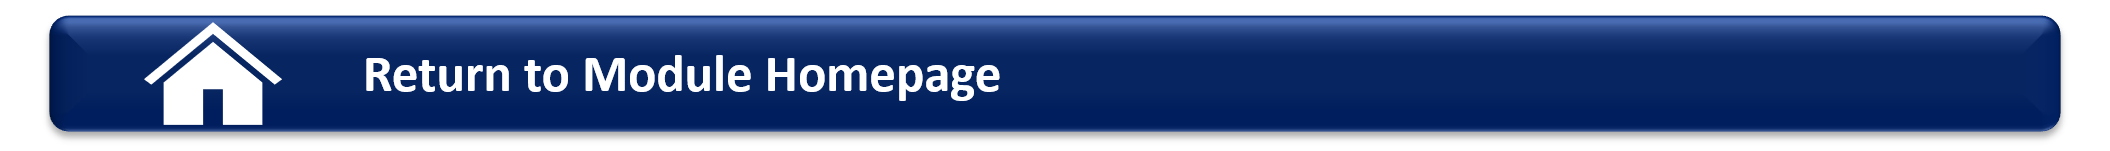](../overview/2.0--Module-2--GridAPPS-D-Overview.ipynb)

---

![gridappsd-logo](../images/GridAPPS-D_narrow.png)